# Training a dense neural network

Let's focus on the problem of handwritten digit recognition. It is a classification problem, because for each input image we need to specify the class - which digit it is.

In this unit, we start with the simplest possible approach for image classification - a fully-connected neural network (which is also called a *perceptron*). We will recap the way neural networks are defined in PyTorch, and how the training algorithm works. If you are familiar with those concepts - feel free to skip to the next unit, where we introduce Convolutional Neural Networks (CNNs).

We use `pytorchcv` helper to load all data we have talked about in the previous unit.

In [1]:
import torch 
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.data import DataLoader



In [2]:
from torchvision import datasets, transforms

data_train = datasets.MNIST(root = 'data', train = True, download = True, transform = transforms.ToTensor())
data_test = datasets.MNIST(root = 'data', train = False, download = True, transform = transforms.ToTensor())


## Fully-connected dense neural networks

A basic **neural network** in PyTorch consists of a number of **layers**. The simplest network would include just one fully-connected layer, which is called **Linear** layer, with 784 inputs (one input for each pixel of the input image) and 10 outputs (one output for each class).

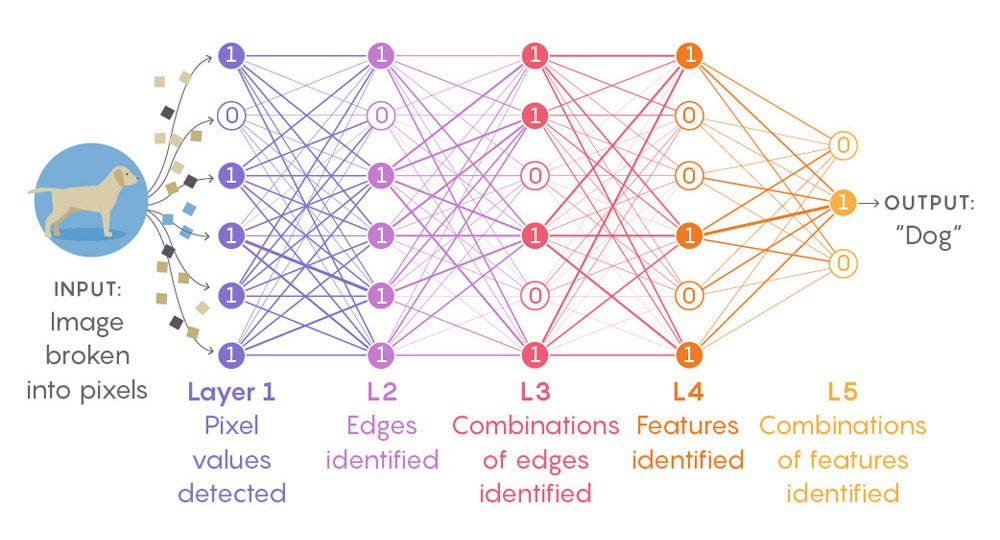

As we discussed above, the dimension of our digit images is $1\times28\times28$, i.e. each image contains $28\times28=784$ different pixels. Because linear layer expects its input as one-dimensional vector, we need to insert another layer into the network, called **Flatten**, to change input tensor shape from $1\times28\times28$ to $784$.

After `Flatten`, there is a main linear layer (called `Dense` in PyTorch terminology) that converts 784 inputs to 10 outputs - one per class. We want $n$-th output of the network to return the probability of the input digit being equal to $n$.

Because the output of a fully-connected layer is not normalized to be between 0 and 1, it cannot be thought of as probability. Moreover, if want outputs to be probabilities of different digits, they all need to add up to 1. To turn output vectors into probability vector, a function called **Softmax** is often used as the last activation function in a classification neural network. For example, $\mathrm{softmax}([-1,1,2]) = [0.035,0.25,0.705]$.

> In PyTorch, we often prefer to use **LogSoftmax** function, which will also compute logarithms of output probabilities. To turn the output vector into the actual probabilities, we need to take **torch.exp** of the output. 

Thus, the architecture of our network can be represented by the following sequence of layers:

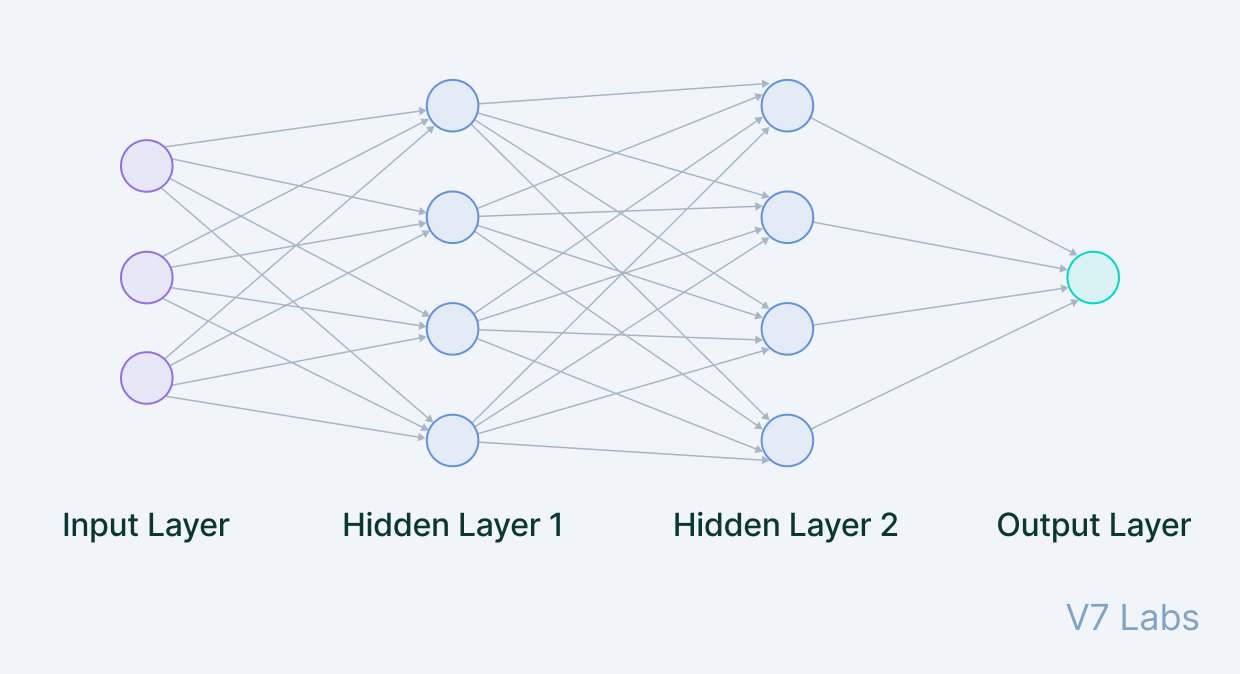


It can be defined in PyTorch in the following way, using `Sequential` syntax:

In [3]:
net=nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),
    nn.LogSoftmax(dim=1)
)

This sequence of layers is shown below in more detail. For all vectors in this diagram we also indicate tensor size.


On the right hand side of this diagram we also have expected network output, represented as one-hot encoded vector. Expected output is compared with the actual output of our network using **loss function**, that gives one number - loss - as an output. Our goal during network training is to minimize this loss by adjusting model parameters - layer weights.

## Training the network

A network defined in this way can take any digit as input and produce a vector of probabilities as an output. Let's see how this network performs by giving it a digit from our dataset:

In [4]:
print('Digit to be predicted:', data_train[0][1])
torch.exp(net(data_train[0][0]))

Digit to be predicted: 5


tensor([[0.0999, 0.0807, 0.1174, 0.0830, 0.0913, 0.0951, 0.0958, 0.1050, 0.1011,
         0.1307]], grad_fn=<ExpBackward0>)

> Because we use `LogSoftmax` as final activation of our network, we pass network output through `torch.exp` to get probabilities.

As you can see the network predicts similar probabilities for each digit. This is because it has not been trained on how to recognize the digits. We need to give it our training data to train it on our dataset.

To train the model we will need to create **batches** from our dataset of a certain size, let's say 64. PyTorch has an object called **DataLoader** that can create batches of our data for us automatically:

In [5]:
train_loader=DataLoader(data_train, batch_size=64)
test_loader=DataLoader(data_test, batch_size=64)

The training process steps are as follows:

1. We take a minibatch from the input dataset, which consists of input data (features) and expected result (label).
2. We calculate the predicted result for this minibatch. 
3. The difference between this result and expected result is calculated using a special function called the **loss function**. Loss function shows how different the output of the network is from the expected output. The goal of our training is to minimize the loss. 
4. We calculate the gradients of this loss function with respect to model weights (parameters), which are then used to adjust the weights to optimize the performance of the network. The amount of adjustment is controlled by a parameter called **learning rate**, and the details of optimization algorithm are defined in the **optimizer** object.
5. We repeat those steps until the whole dataset is processed. One complete pass through the dataset is called **an epoch**. 

Here is a function that performs one epoch training: 

In [6]:
epochs=5
learning_rate=1e-3
optimizer=None

In [7]:
def train_epochs(net,dataloader,lr=learning_rate,optimizer=optimizer,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    total_loss,acc,count=0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        out=net(features)
        loss = loss_fn(out,labels) #Cross entropy (out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted=torch.max(out,dim=1)
        acc+=predicted.eq(labels).sum()
        count+=len(labels)
        
    return total_loss.item()/count,acc.item()/count


train_epochs(net,train_loader)



(0.008581277465820313, 0.86785)

In [8]:
def validate(net,dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss=0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels)
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)       
    return loss.item()/count,acc.item()/count

validate(net,test_loader)

(0.005272665405273437, 0.9088)

Similarly to `train` function, we return average loss and accuracy on test dataset.

## Overfitting

Normally when training a neural network, we train the model for several epochs observing training and validation accuracy. In the beginning, both training and validation accuracy should increase, as the network picks up the patterns in the dataset. However, at some point it can happen that training accuracy increases while validation accuracy starts to decrease. That would be an indication of **overfitting**, that is model does well on your training dataset, but not on new data.

Below is the training function that can be used to perform both training and validation. It prints the training and validation accuracy for each epoch, and also returns the history that can be used to plot the loss and accuracy on the graph.

In [9]:
def train(net,train_loader,test_loader,optimizer=optimizer,lr=learning_rate,epochs=epochs,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    res={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
    
    for ep in range(epochs):
        tl,ta=train_epochs(net,train_loader,lr,optimizer,loss_fn)
        vl,va=validate(net,test_loader,loss_fn)
        print(f'Epoch {ep+1}/{epochs}: train_loss={tl:.4f}, train_acc={ta:.4f}, val_loss={vl:.4f}, val_acc={va:.4f}')
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
        
    return res

net=nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),
    nn.LogSoftmax(dim=1)
)

hist=train(net,train_loader,test_loader,epochs=5)

Epoch 1/5: train_loss=0.0086, train_acc=0.8665, val_loss=0.0053, val_acc=0.9098
Epoch 2/5: train_loss=0.0051, train_acc=0.9090, val_loss=0.0047, val_acc=0.9172
Epoch 3/5: train_loss=0.0047, train_acc=0.9167, val_loss=0.0044, val_acc=0.9192
Epoch 4/5: train_loss=0.0045, train_acc=0.9204, val_loss=0.0043, val_acc=0.9224
Epoch 5/5: train_loss=0.0043, train_acc=0.9228, val_loss=0.0043, val_acc=0.9241


This function logs messages with the accuracy on training and validation data from each epoch. It also returns this data as a dictionary (called **history**). We can then visualize this data to better understand our model training.

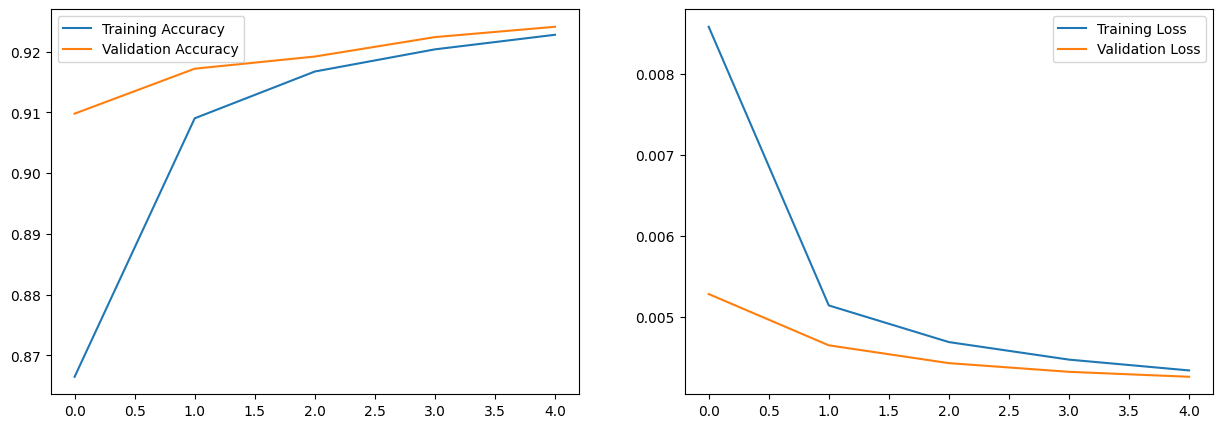

In [10]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(hist['train_acc'],label='Training Accuracy')
plt.plot(hist['val_acc'],label='Validation Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['train_loss'],label='Training Loss')
plt.plot(hist['val_loss'],label='Validation Loss')
plt.legend()



The diagram on the left shows the `training accuracy` increasing (which corresponds to the network learning to classify our training data better and better), while `validation accuracy` starts to fall. The diagram on the right show the `training loss` and `validation loss`, you can see the `training loss` decreasing (meaning its performing better) and the `validation loss` increasing (meaning its performing worse). These graphs would indicate the model is **overfitted**. 

## Visualizing network weights

The `Dense` layer in our network is also called *linear*, because it performs linear transformation of its input, which can be defined as $y=Wx+b$, where $W$ is a matrix of weights, and $b$ is bias. Weights matrix $W$ is in fact responsible for what our network can do, i.e. for recognizing digits. In our case, it has size of $784\times10$, because it produces 10 outputs (one output per digit) for an input image.

Lets visualize our weights of our neural network and see what they look like. When the network is more complex than just one layer it can be a difficult to visualize the results like this, because in complex network weights do not make much sense when visualized. However, in our case each of 10 dimensions of weight matrix $W$ correspond to individual digits, and thus can be visualized to see how the digit recognition takes place. For example, if we want to see if our number is 0 or not, we will multiply input digit by $W[0]$ and pass the result through a softmax normalization to get the answer. 

In the code below, we will first get the matrix $W$ into `weight_tensor` variable. It can be obtained by calling the `net.parameters()` method (which returns both $W$ and $b$), and then calling `next` to get the first of two parameters. Then we will go over each dimension, reshape it to $28\times28$ size, and plot. You can see that 10 weight tensor dimensions somewhat resemble the average shape of the digits they classify:

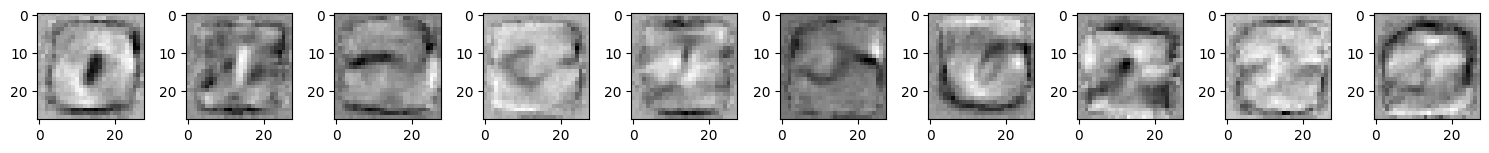

In [11]:
weight_tensor = next(net.parameters())
fig,ax=plt.subplots(1,10,figsize=(15,5))

for i,x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).detach(),cmap='gray')
plt.tight_layout()

### Multi-layered perceptron

To further increase accuracy, we may want to include one or more **hidden layers**.

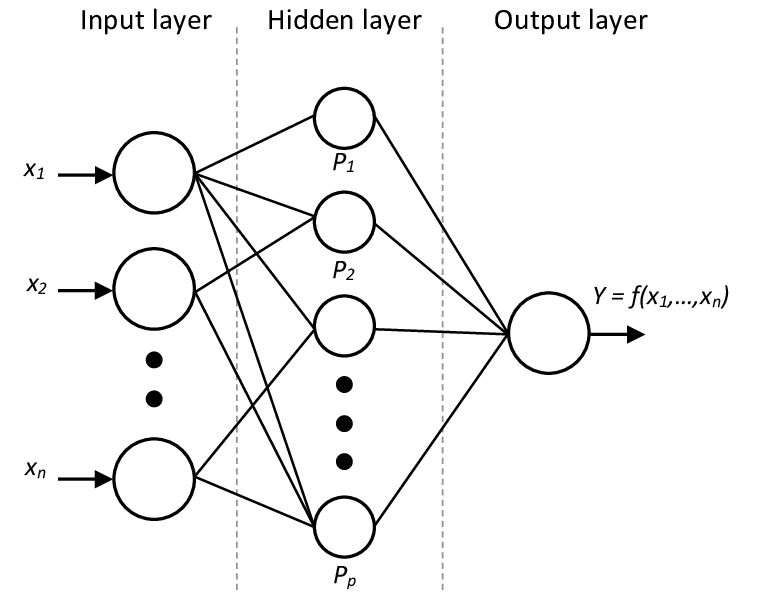

Our network layer structure will look like this:

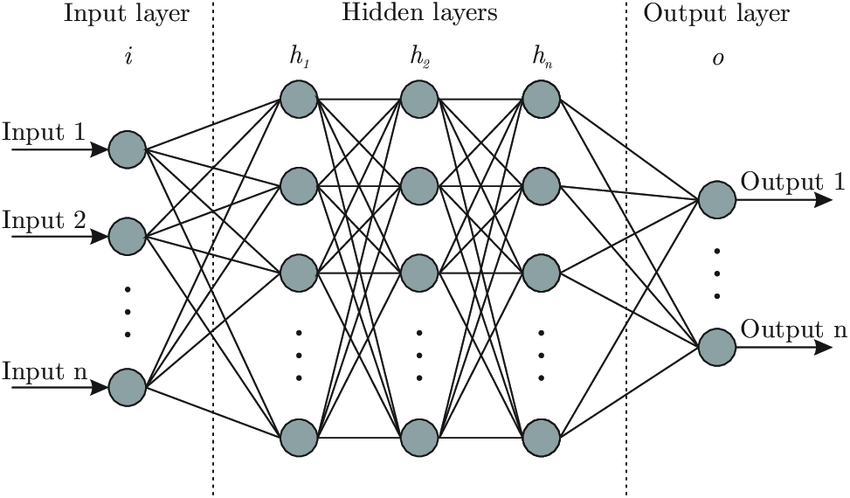

An important thing to note here is the non-linear activation function between layers, called **ReLU**. It is important to introduce those non-linear activation functions, because they are one of the reasons neural networks achieve high expressive power. Indeed, it can be demonstrated mathematically that if a network consisted just of a series of linear layers, it would essentially be equivalent to one linear layer. Thus inserting non-linear functions in between layers is important!

**ReLU** is a simplest activation function, which is defined as follows:

$$
\mathrm{ReLU}(x) = \begin{cases} 0 & x<0 \\ x & x\ge0 \end{cases}
$$

Other activation functions used in deep learning are sigmoid and tanh, but ReLU is most often used in computer vision, because it can be quickly computed, and using other functions does not bring any significant benefits.


This network can be defined in PyTorch with this code:

In [12]:
net=nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
)

summary(net,input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─ReLU: 1-3                              [1, 100]                  --
├─Linear: 1-4                            [1, 10]                   1,010
├─LogSoftmax: 1-5                        [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

In [13]:
from torch.nn.functional import relu,log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet,self).__init__()
        self.flatten=nn.Flatten()
        self.hidden=nn.Linear(784,100)
        self.out=nn.Linear(100,10)
        
    def forward(self,x):
        x=self.flatten(x)
        x=self.hidden(x)
        x=relu(x)
        x=self.out(x)
        x=log_softmax(x,dim=0)
        
        return x
net=MyNet()

summary(net,input_size=(1,28,28),device='cpu')
        
        

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─Linear: 1-3                            [1, 10]                   1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

You can see that the structure of a neural network is the same as with the Sequential-defined network, but the definition is more explicit. Our custom neural network is represented by a class inherited from torch.nn.Module class.

Class definition consists of two parts:

In the constructor (__init__) we define all layers that our network will have. Those layers are stored as internal variables of the class, and PyTorch will automatically know that parameters of those layers should be optimized when training. Internally, PyTorch uses parameters() method to look for all trainable parameters, and nn.Module will automatically collect all trainable parameters from all sub-modules.
We define the forward method that does the forward pass computation of our neural network. In our case, we start with a parameter tensor x, and explicitly pass it through all the layers and activation functions, starting from flatten, up to final linear layer out. When we apply our neural network to some input data x by writing out = net(x), the forward method is called.
In fact, Sequential networks are represented in a very similar manner, they just store a list of layers and apply them sequentially during the forward pass. Here we have a chance to represent this process more explicitly, which eventually gives us more flexibility. That is one of the reasons that using classes for neural network definition is a recommended and preferred practice.

You can now try to train this network using exactly the same train function that we've defined above:

In [14]:
hist = train(net,train_loader,test_loader,epochs=5)



Epoch 1/5: train_loss=0.0371, train_acc=0.9065, val_loss=0.0340, val_acc=0.9426
Epoch 2/5: train_loss=0.0335, train_acc=0.9487, val_loss=0.0329, val_acc=0.9569
Epoch 3/5: train_loss=0.0327, train_acc=0.9601, val_loss=0.0325, val_acc=0.9627
Epoch 4/5: train_loss=0.0323, train_acc=0.9673, val_loss=0.0322, val_acc=0.9663
Epoch 5/5: train_loss=0.0320, train_acc=0.9721, val_loss=0.0321, val_acc=0.9680


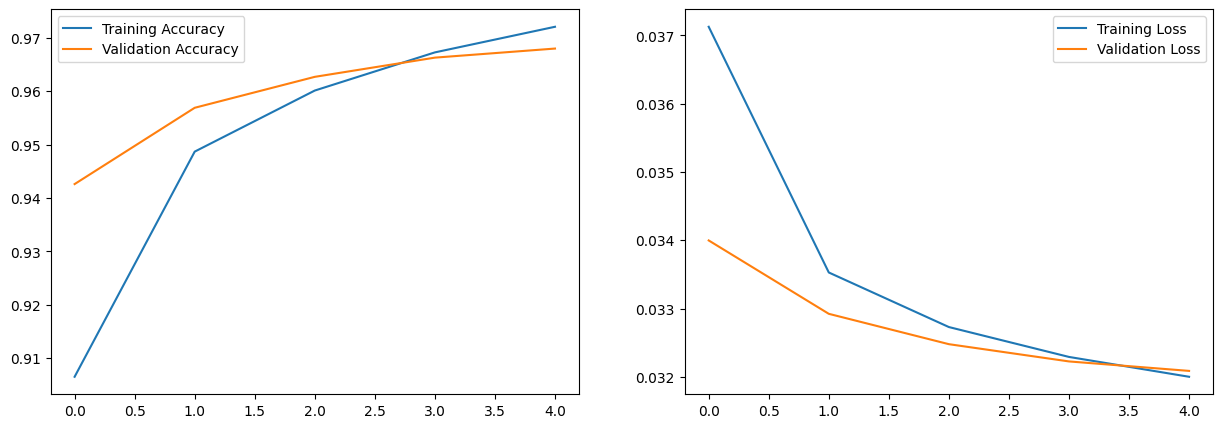

In [15]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(hist['train_acc'],label='Training Accuracy')
plt.plot(hist['val_acc'],label='Validation Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['train_loss'],label='Training Loss')
plt.plot(hist['val_loss'],label='Validation Loss')
plt.legend()



## Takeaway 

Training a neural network in PyTorch can be programmed with a training loop. It may seem like a complicated process, but in real life we need to write it once, and we can then re-use this training code later without changing it.

We can see that a single-layer and multi-layer dense neural networks show relatively good performance, but if we try to apply them to real-world images, the accuracy will not be too high. In the next unit, we will introduce the concept of **convolutions**, which allow us to get much better performance for image recognition.  